Chris has
* Initiated 8 crosses ("randomly sporulated about 1000 (+/-300) spores per cross (8 crosses)")
* Mapped the reads and did some preliminary coverage / allele frequency plots

Files are on /home/ceberlein/02_ANALYSES/02_TRD/ and /Volumes/SRV-FILE-JS/Projects/TransmissionRatioDistortion_TransPOP_ChrisEberlein

In [10]:
# He aligned with bwa mem and sorted the files with samtools, both default options
dir(path="/home/ceberlein/02_ANALYSES/02_TRD/01_Alignment_to_REF/", ".sorted.bam$")

[1] "TRDC01ACPxBFP.sorted.bam" "TRDC02BAPxCMP.sorted.bam"
[3] "TRDC03CCDxCPG.sorted.bam" "TRDC04ATExYCR.sorted.bam"
[5] "TRDC05ACKxACV.sorted.bam" "TRDC06AKExBAH.sorted.bam"
[7] "TRDC07BAHxCGD.sorted.bam" "TRDC08ANGxCEI.sorted.bam"

In [12]:
library(data.table)

In [15]:
#The coverage files are output from samtools depth
dir(path="/home/ceberlein/02_ANALYSES/02_TRD/01_Alignment_to_REF/", "coverage$")

#they are aggregated into
df_coverage_chris<-fread("/home/ceberlein/02_ANALYSES/02_TRD/02_Coverage_AlleleFreq/Coverage_TRD_Scerevisiae.csv", data.table = FALSE)
head(df_coverage_chris)

[1] "TRDC01ACPxBFP.coverage" "TRDC02BAPxCMP.coverage" "TRDC03CCDxCPG.coverage"
[4] "TRDC04ATExYCR.coverage" "TRDC05ACKxACV.coverage" "TRDC06AKExBAH.coverage"
[7] "TRDC07BAHxCGD.coverage" "TRDC08ANGxCEI.coverage"

chrom       species                Start Stop  length_chromosome
1 chromosome1 TRDC01ACPxBFP.coverage     1 10000 230218           
2 chromosome1 TRDC01ACPxBFP.coverage 10001 20000 230218           
3 chromosome1 TRDC01ACPxBFP.coverage 20001 30000 230218           
4 chromosome1 TRDC01ACPxBFP.coverage 30001 40000 230218           
5 chromosome1 TRDC01ACPxBFP.coverage 40001 50000 230218           
6 chromosome1 TRDC01ACPxBFP.coverage 50001 60000 230218           
  sub_window_mean_converage sub_window_median_converage
1  78.08585                  70                        
2  33.99335                  15                        
3  54.09782                  45                        
4 133.76918                 134                        
5 101.82818                  98                        
6  88.42344                  86

In [23]:
library(ggplot2)
library(naturalsort)

In [25]:
df_coverage_chris$chrom_fct=factor(df_coverage_chris$chrom, levels=naturalsort(unique(df_coverage_chris$chrom)))

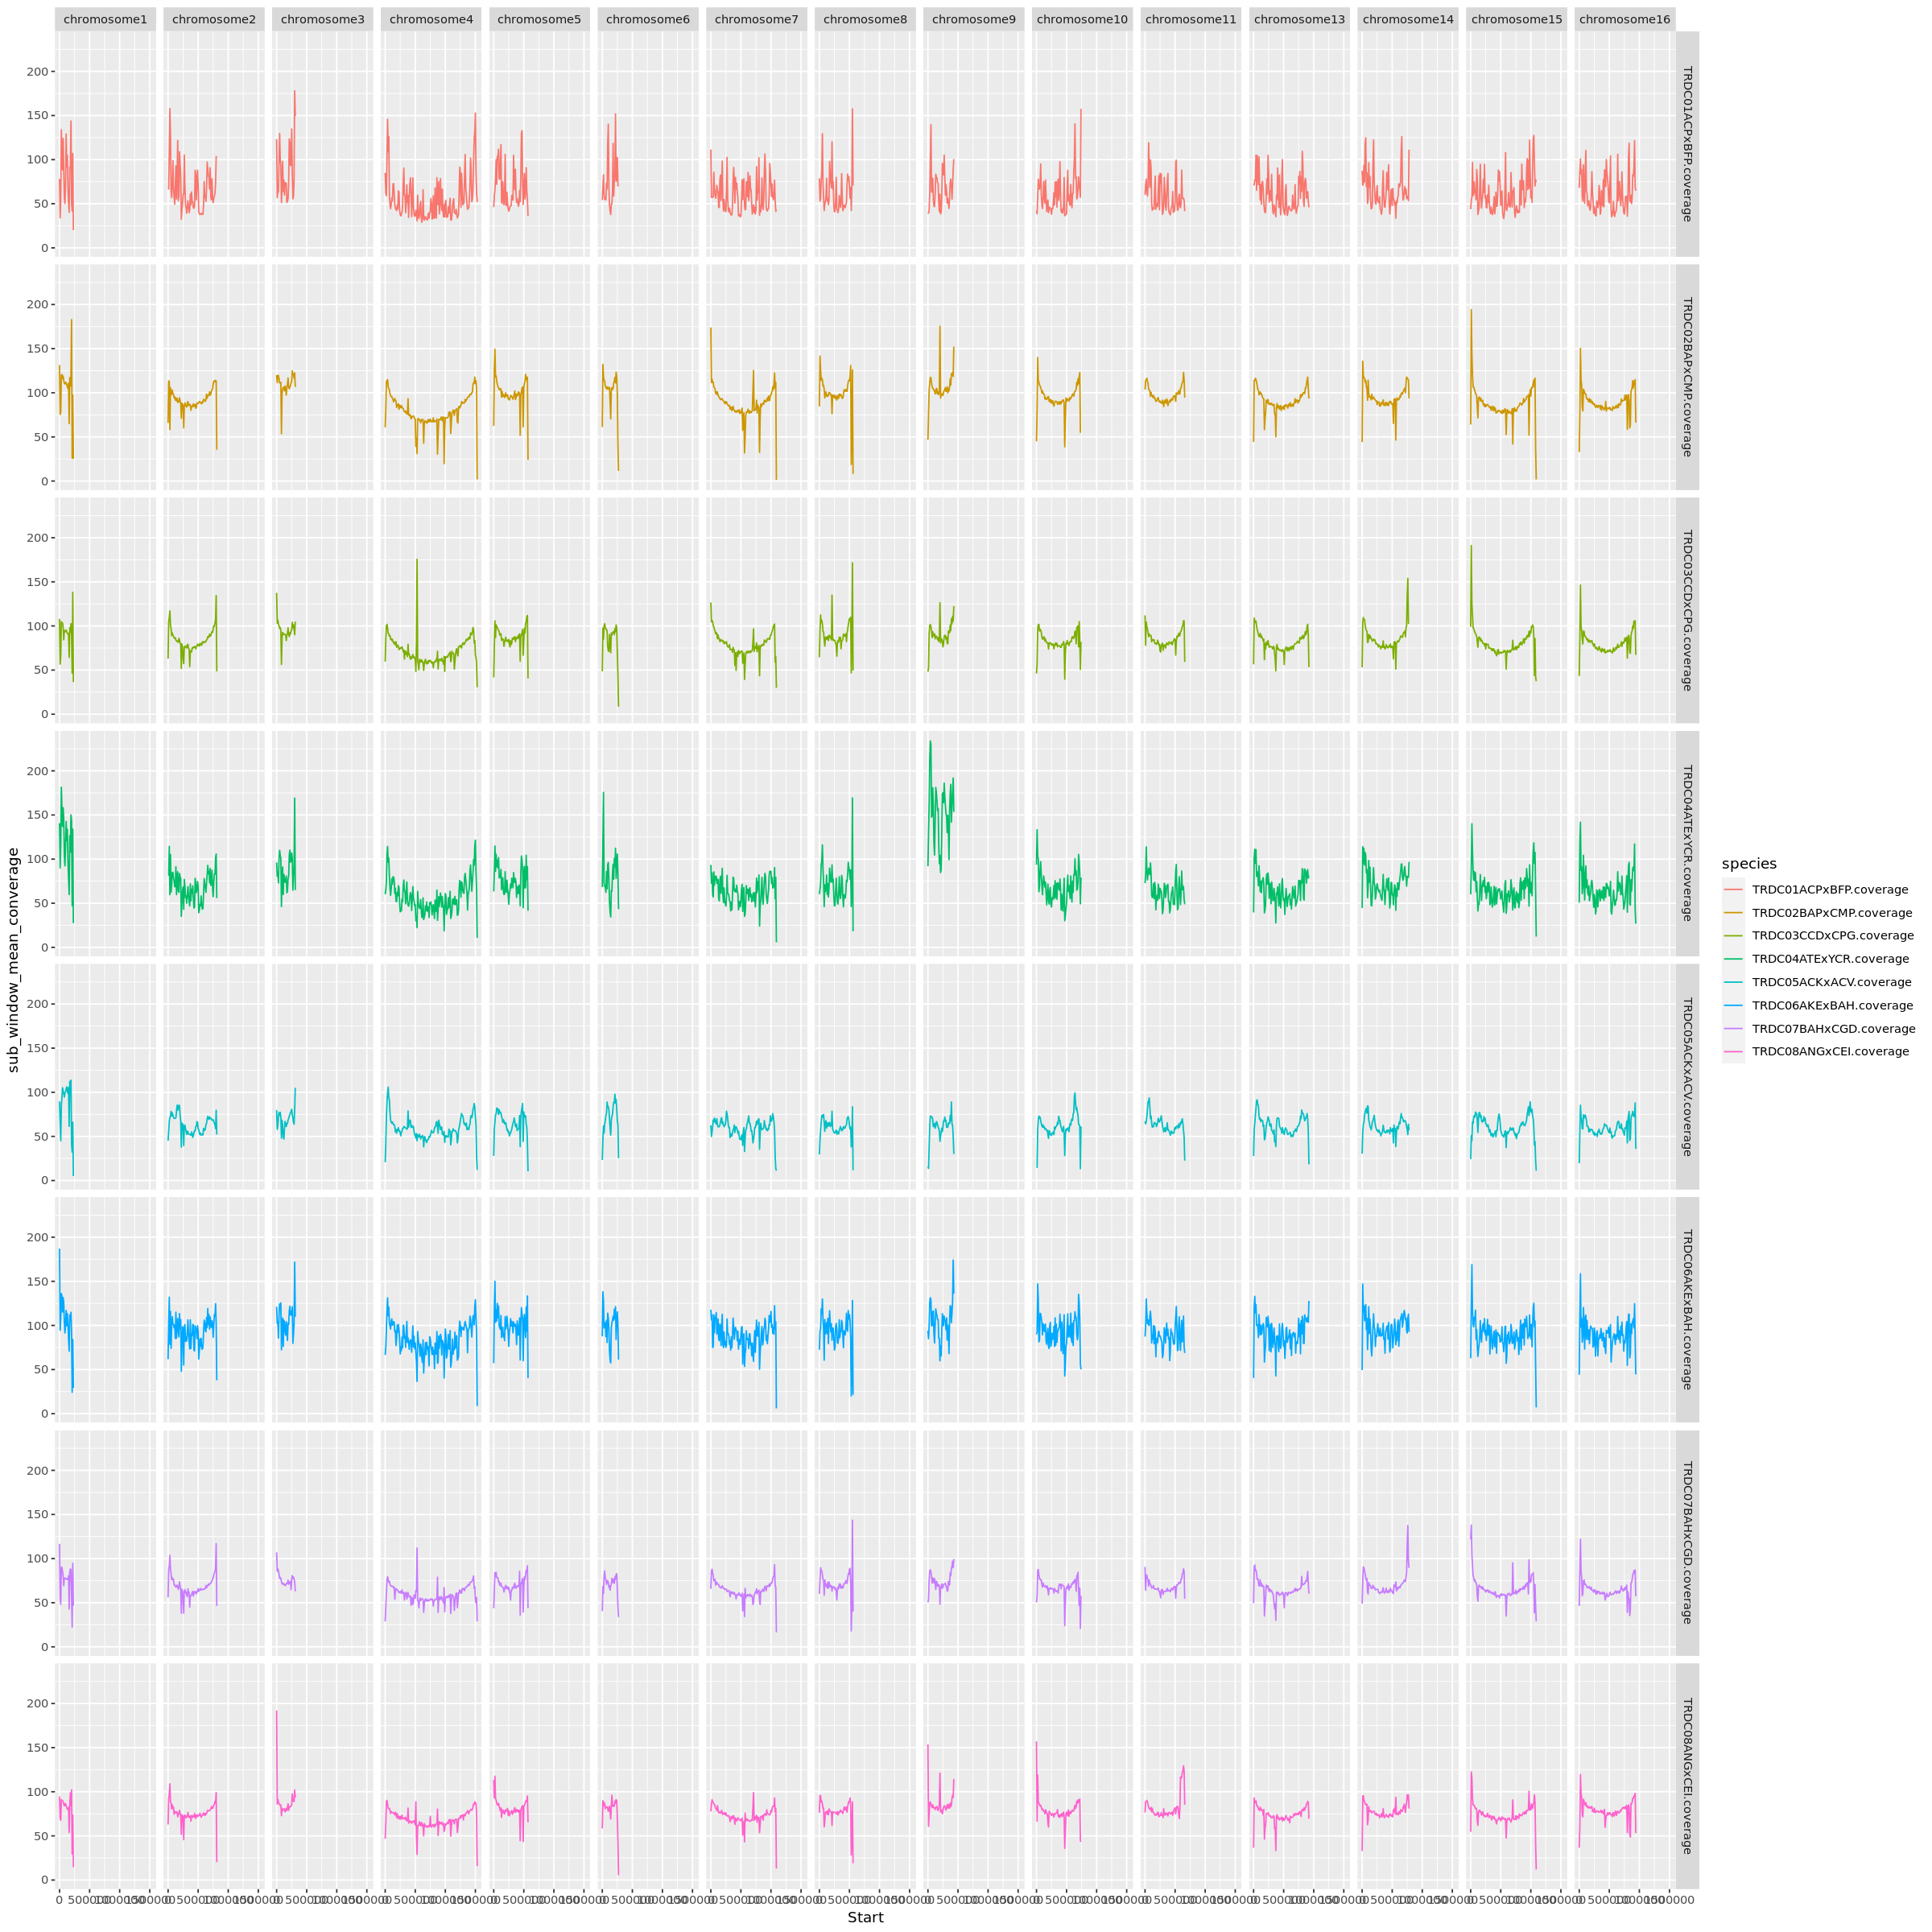

In [26]:
options(repr.plot.width=20, repr.plot.height=20)

df_coverage_chris_plot=subset(df_coverage_chris, !(chrom %in% c("chromosome12","chromosome17")))

ggplot(df_coverage_chris_plot, aes(Start,sub_window_mean_converage,color=species))+
geom_line()+
facet_grid(cols=vars(chrom_fct),rows=vars(species))

There are also vcfs and AF plots, but I cannot find the scripts that generated them.

In [27]:
library(vcfR)


   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****




In [28]:
vcf <- read.vcfR("ceberlein_data/1_ACPxBFP.vcf", verbose = FALSE )

In [32]:
AD <- extract.gt(vcf, element = 'AD', as.numeric = FALSE)

In [37]:
getPart=function(x,which){
    return(as.numeric(strsplit(x, split = ",", fixed = TRUE)[[1]][which]))
}

In [38]:
AD1 = unlist(lapply(AD, getPart, which=1))
AD2 = unlist(lapply(AD, getPart, which=2))

In [40]:
AlleleFrequency=AD1/(AD1+AD2)

In [61]:
MQ <- extract.info(vcf, element = 'MQ', as.numeric = TRUE)
head(MQ)

[1] 32.48 34.07 26.75 26.54 26.63 26.91

In [62]:
df=data.frame(POS=vcfR::getPOS(vcf), CHROM=vcfR::getCHROM(vcf), AF=AlleleFrequency, MQ=MQ)

In [70]:
# scale pos
for(c in unique(df$CHROM)){
    df$POS_scale[df$CHROM==c]=df$POS[df$CHROM==c]/max(df$POS[df$CHROM==c],na.rm=TRUE)
    df$MQ_scale[df$CHROM==c]=df$MQ[df$CHROM==c]-mean(df$MQ[df$CHROM==c],na.rm=TRUE)
    
    df$MQ_scale2[df$CHROM==c]=scale(df$MQ[df$CHROM==c])
}

Warning message:
"Removed 11 rows containing missing values (geom_point)."


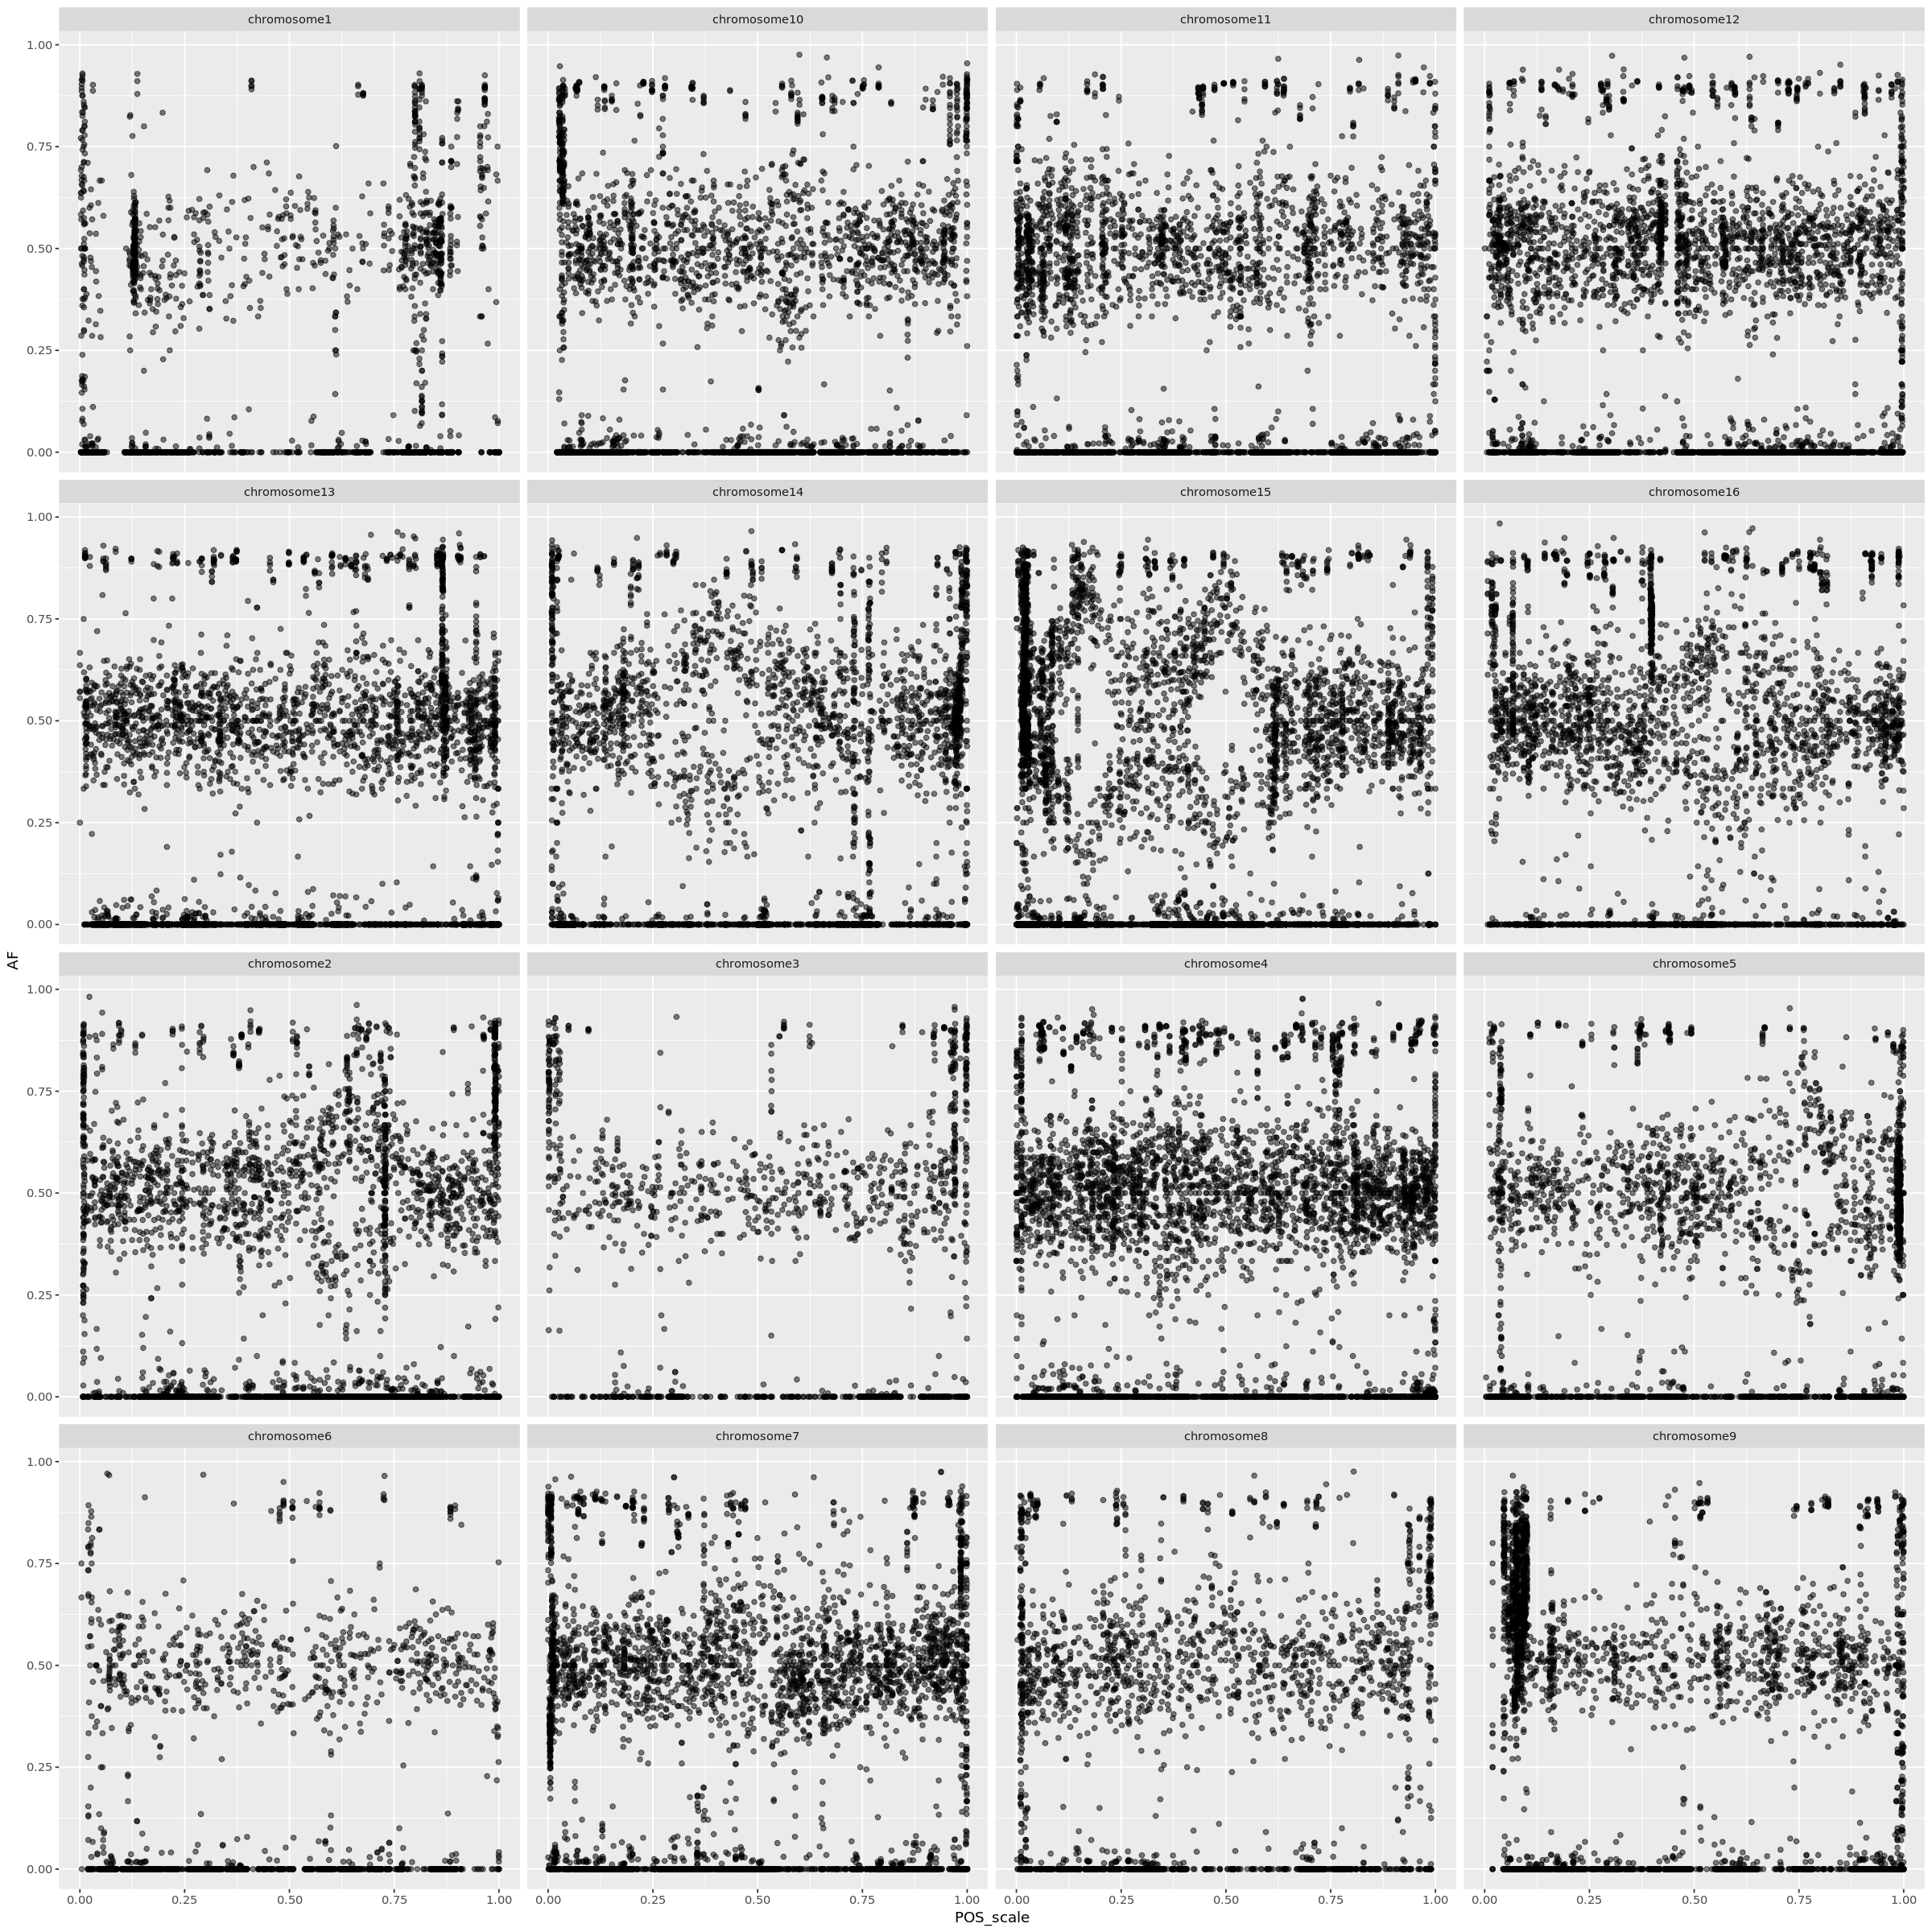

In [72]:
ggplot(df, aes(POS_scale, AF))+
geom_point(alpha=0.5)+
facet_wrap(~CHROM)

Warning message:
"Removed 1 rows containing missing values (geom_point)."


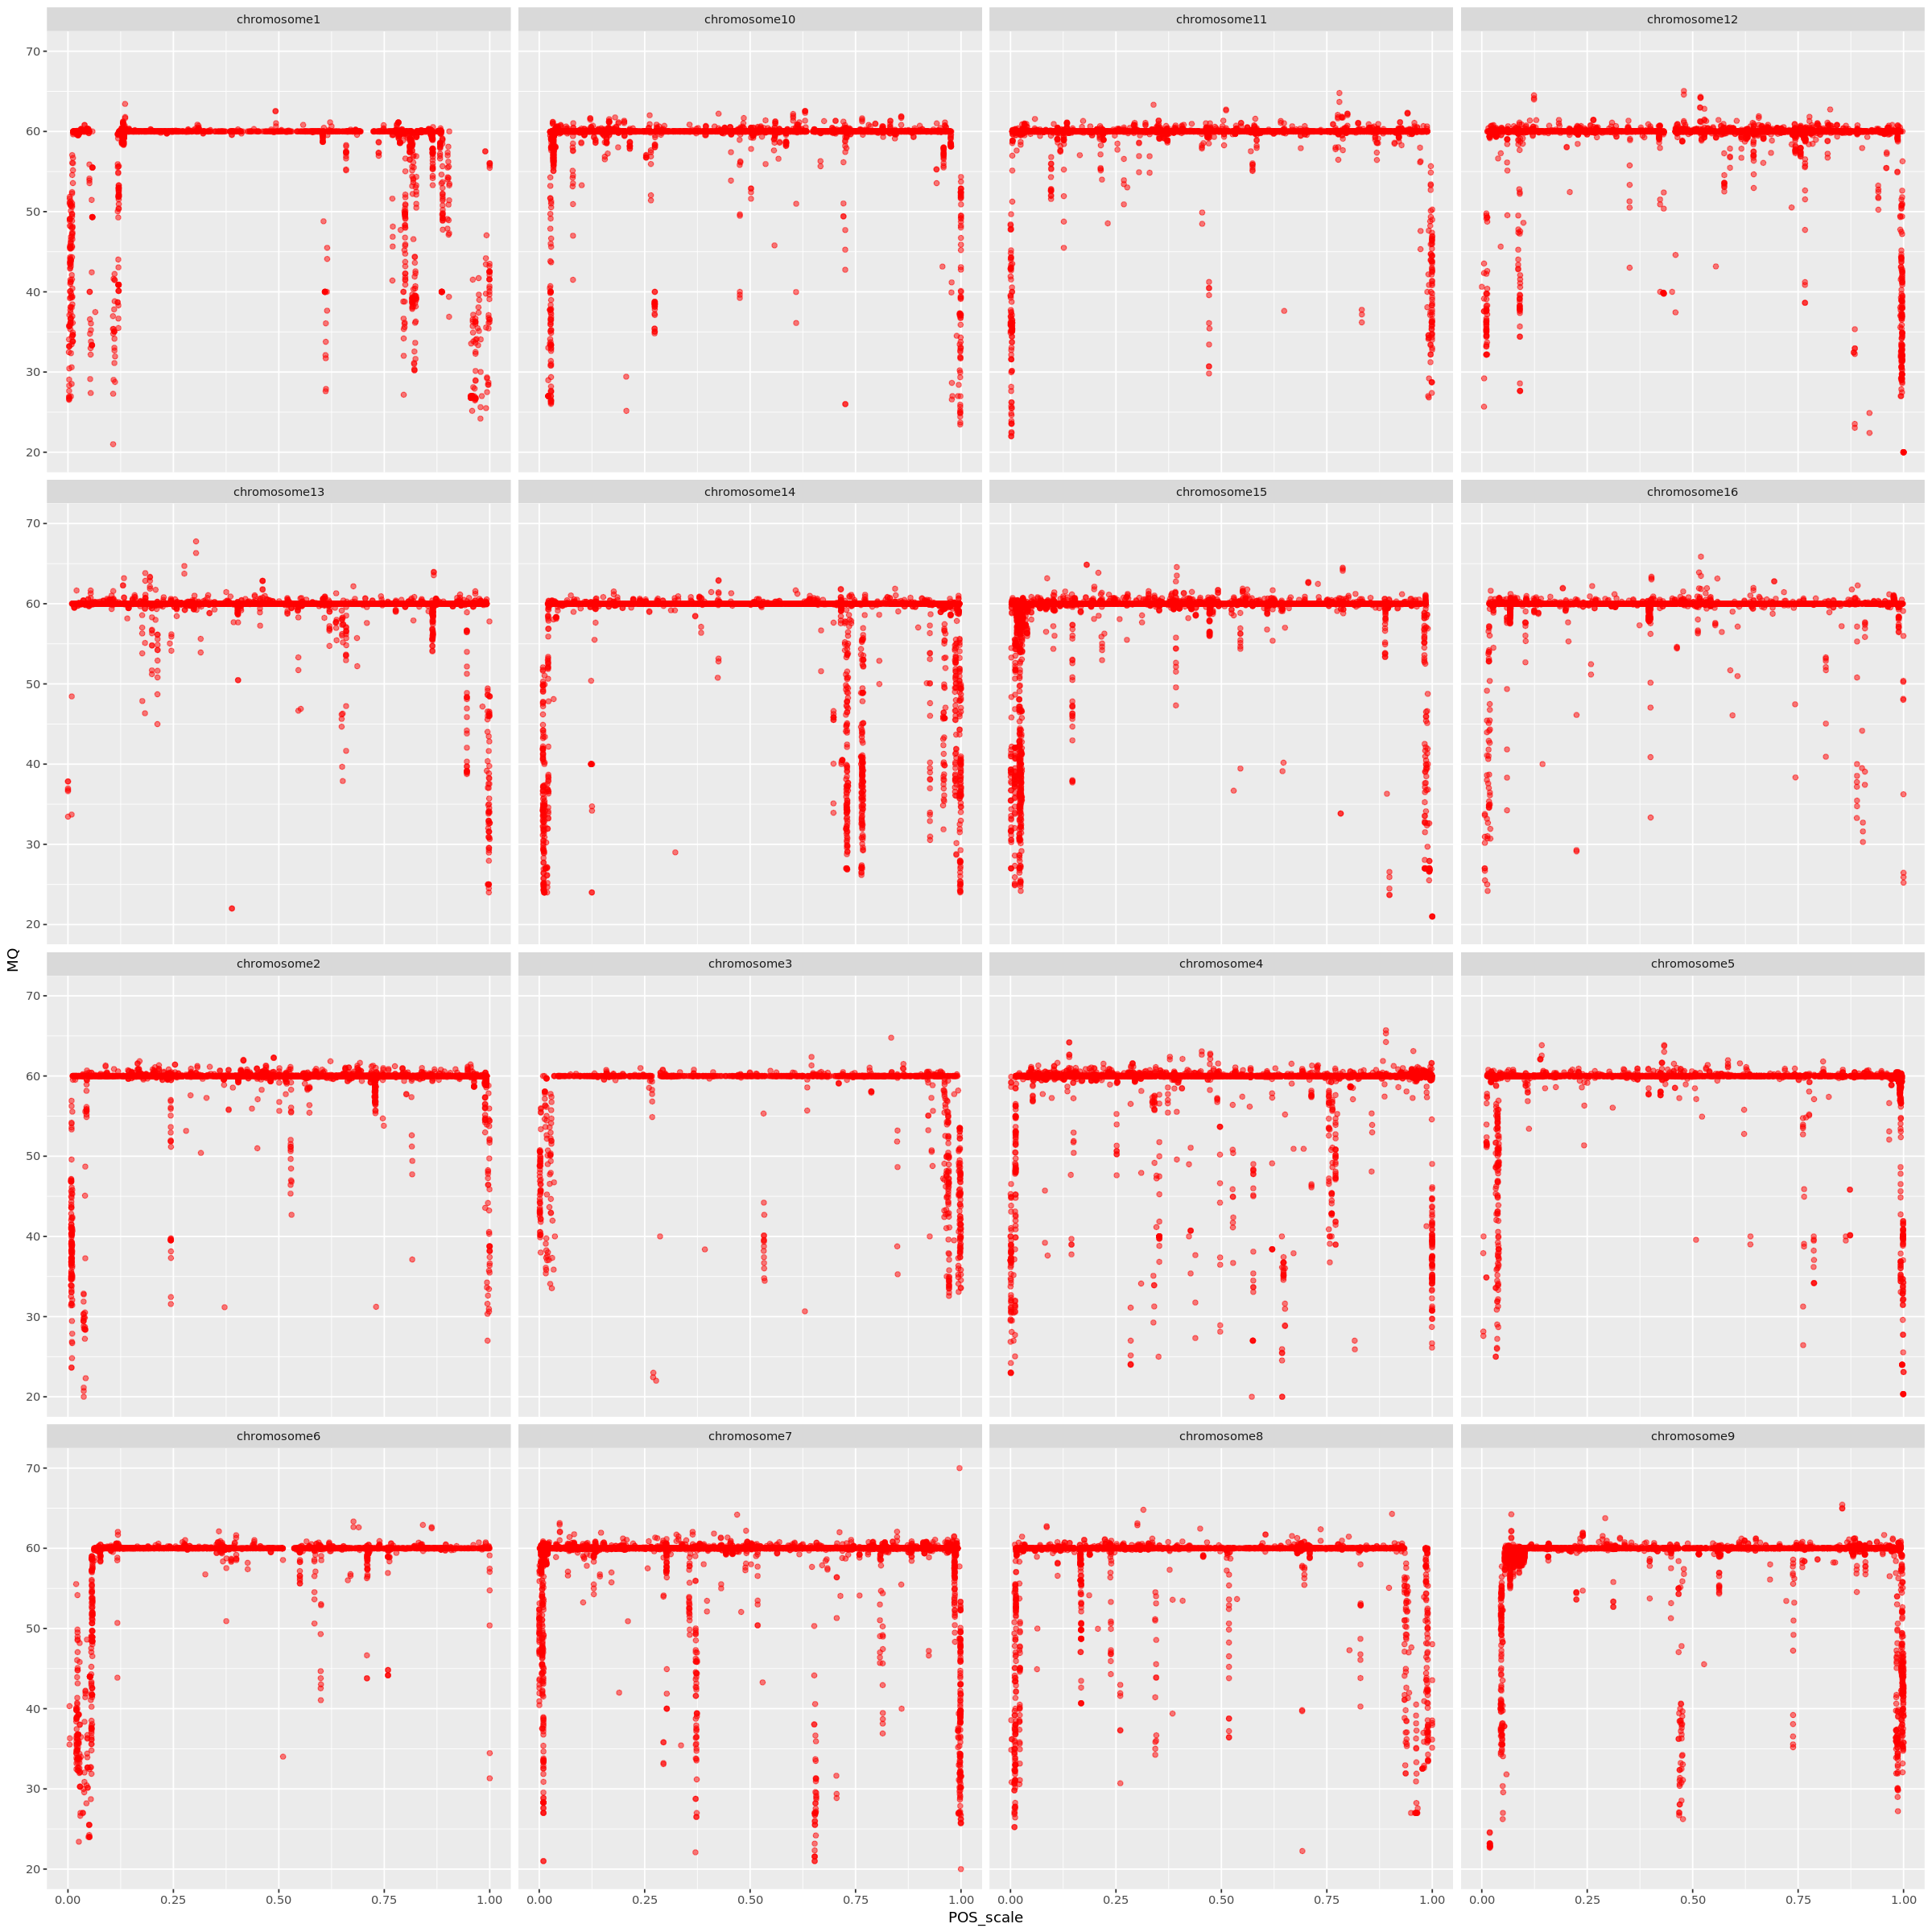

In [73]:
ggplot(df, aes(POS_scale, MQ))+
geom_point(alpha=0.5,color="red")+
facet_wrap(~CHROM)

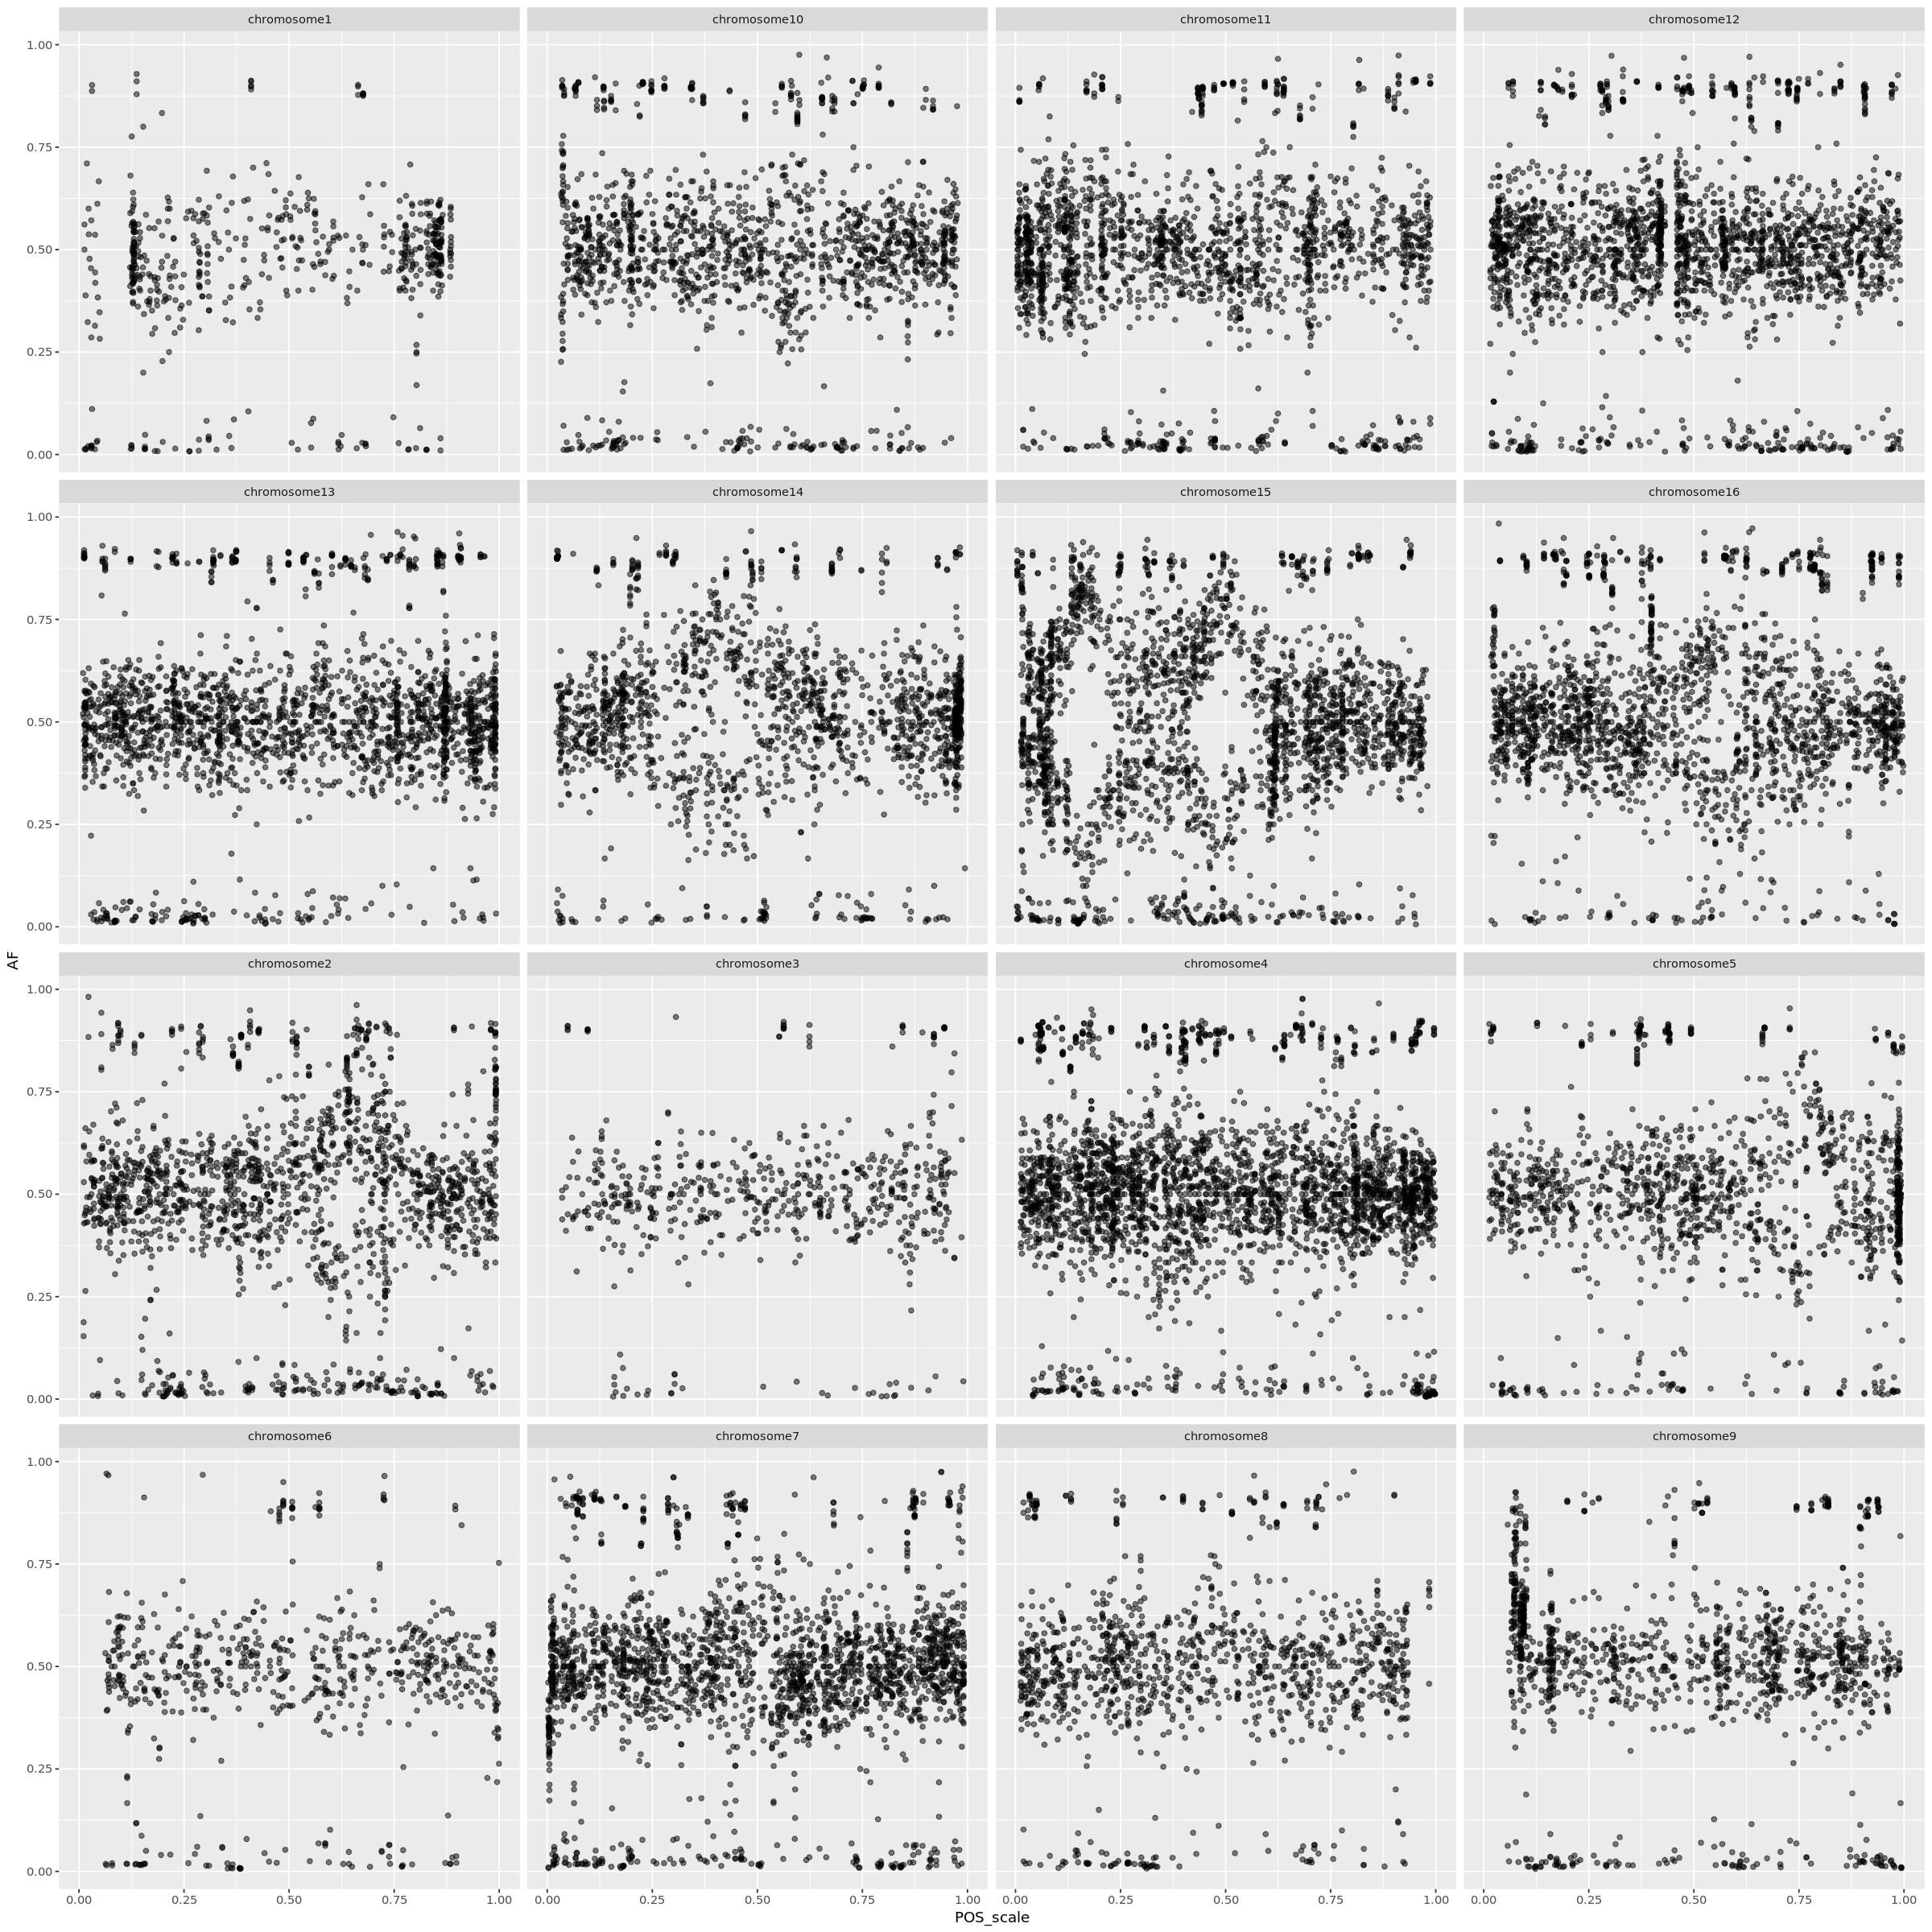

In [76]:
ggplot(subset(df, MQ>=60 & AF > 0), aes(POS_scale, AF))+
geom_point(alpha=0.5)+
facet_wrap(~CHROM)

In [78]:
# filter for non-mean covered regions

[1] 57.69687

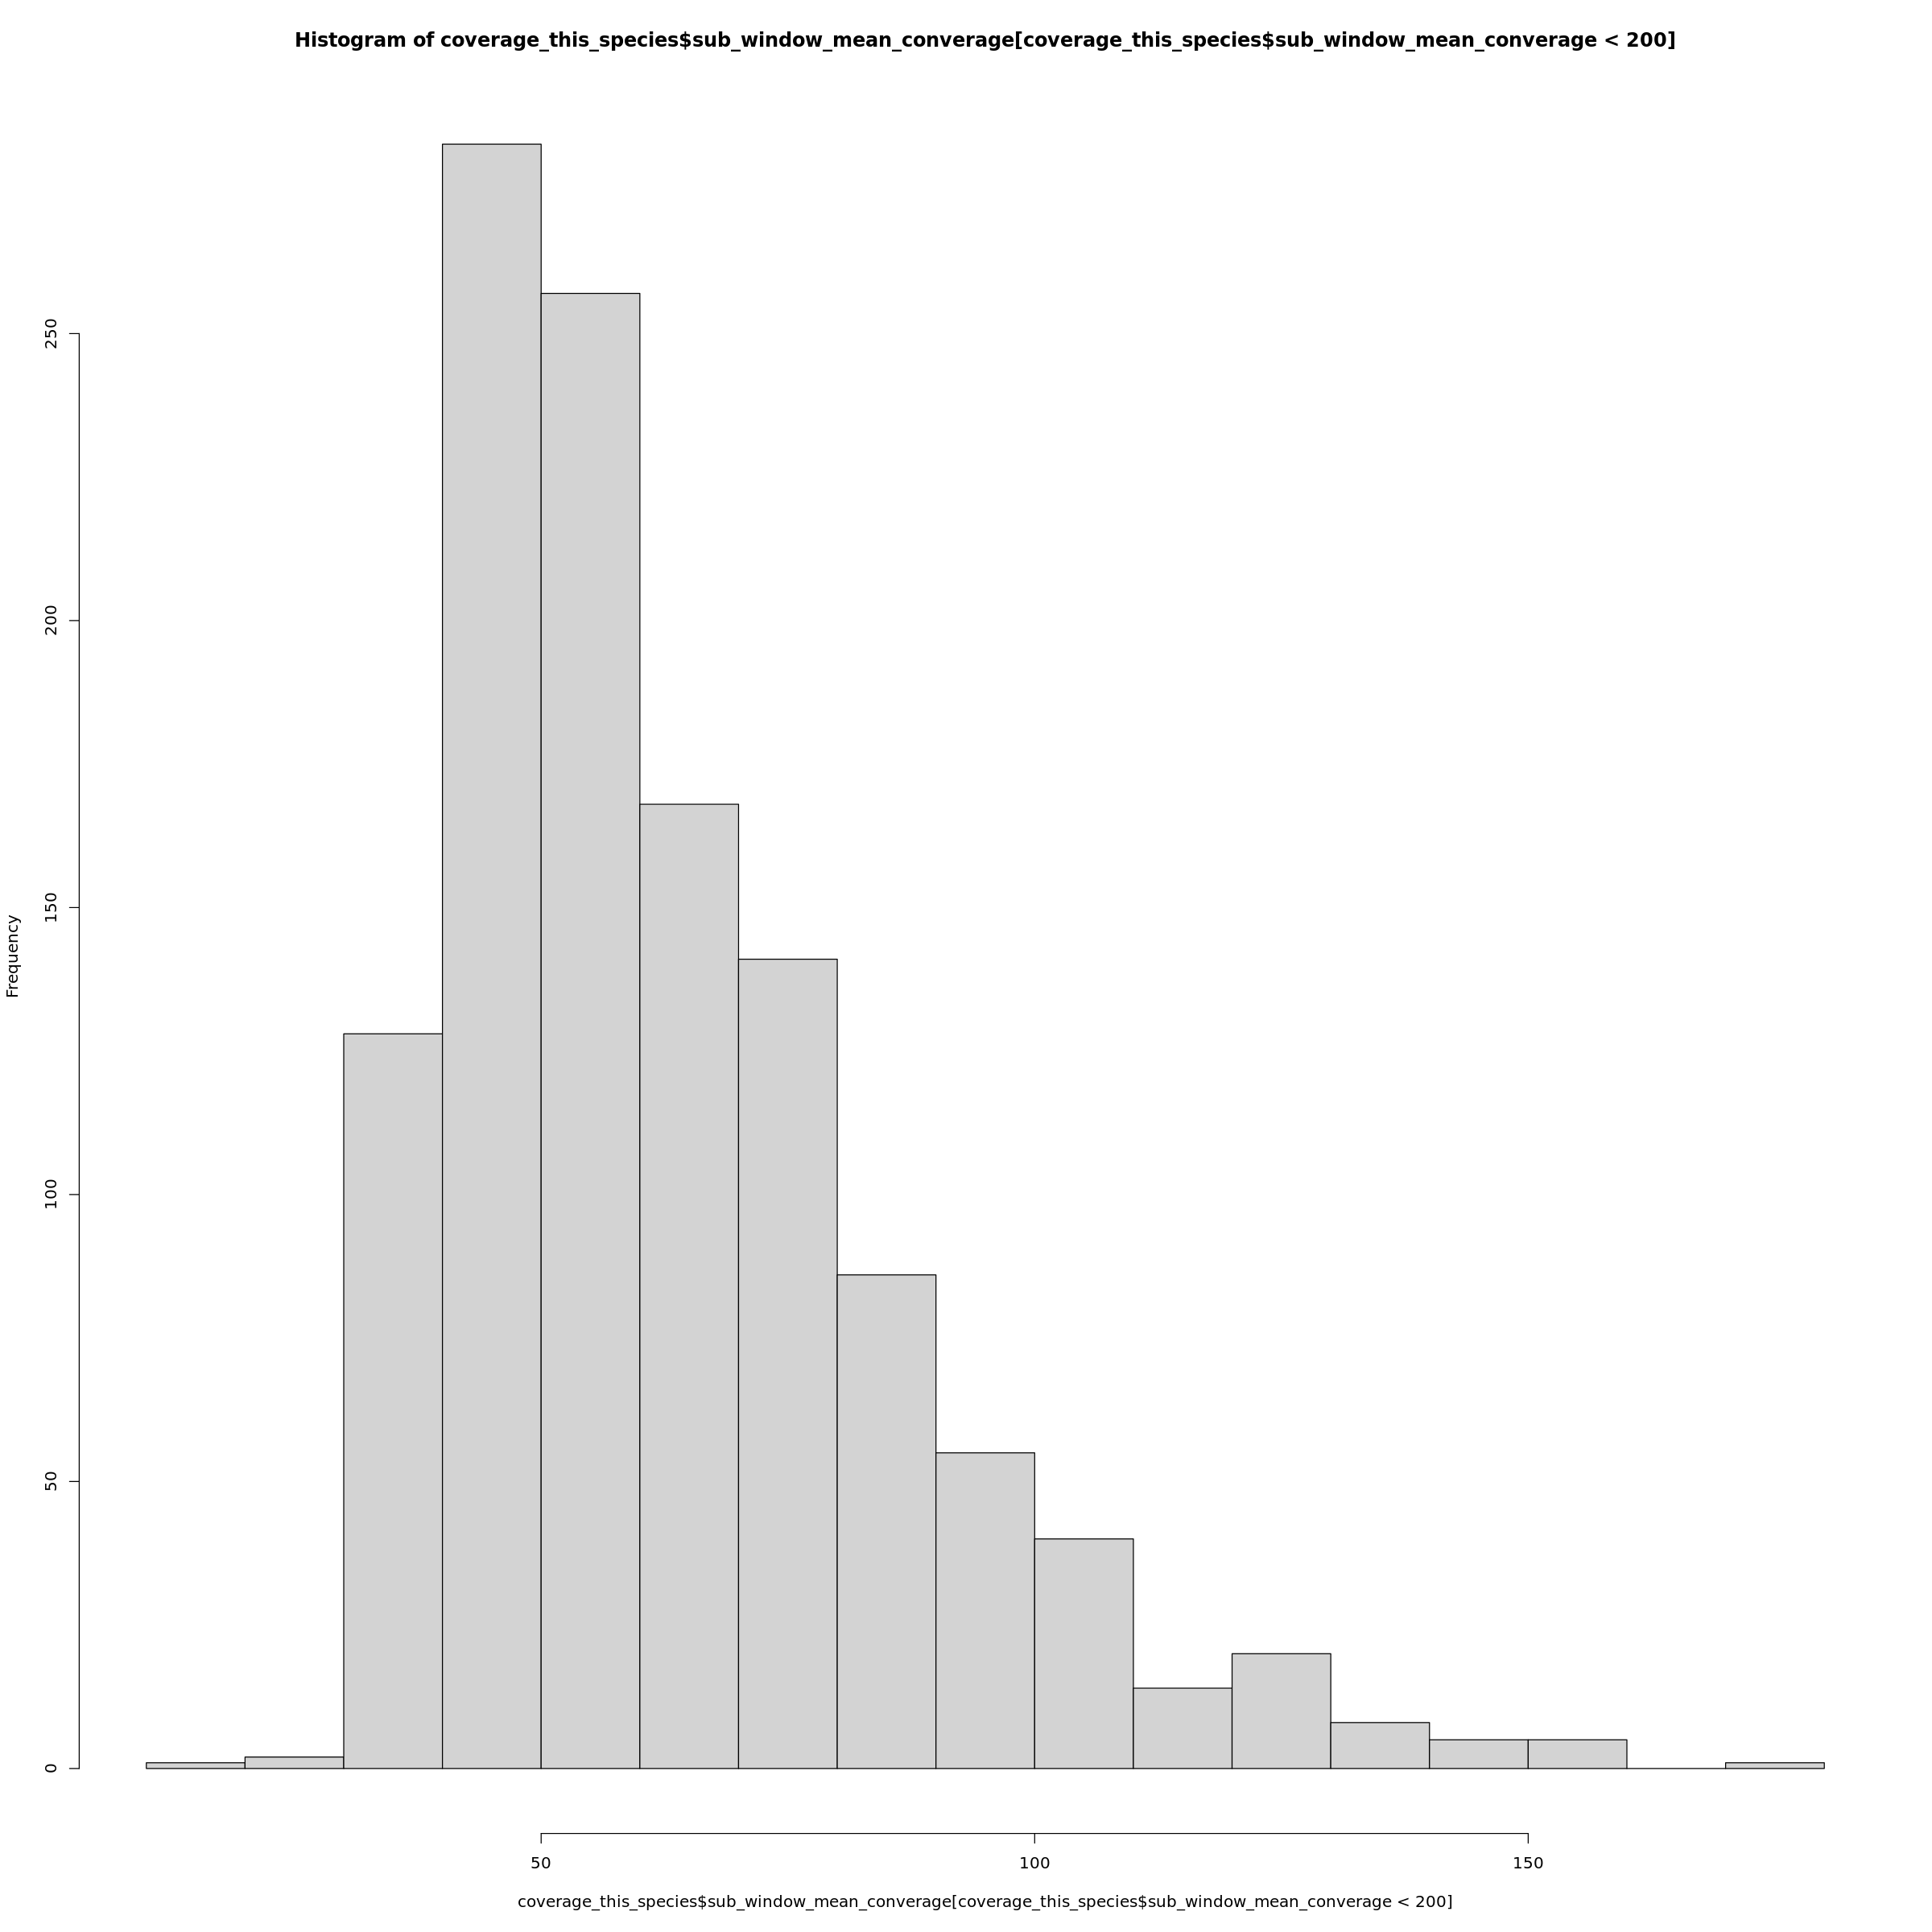

In [85]:
coverage_this_species=subset(df_coverage_chris, species=="TRDC01ACPxBFP.coverage")
median(coverage_this_species$sub_window_mean_converage)
hist(coverage_this_species$sub_window_mean_converage[coverage_this_species$sub_window_mean_converage < 200])

In [86]:
filtered_regions=subset(coverage_this_species, sub_window_mean_converage>=40 & sub_window_mean_converage<=80)

In [87]:
head(filtered_regions)
head(df)

chrom       species                Start  Stop   length_chromosome
1  chromosome1 TRDC01ACPxBFP.coverage      1  10000 230218           
3  chromosome1 TRDC01ACPxBFP.coverage  20001  30000 230218           
9  chromosome1 TRDC01ACPxBFP.coverage  80001  90000 230218           
10 chromosome1 TRDC01ACPxBFP.coverage  90001 100000 230218           
11 chromosome1 TRDC01ACPxBFP.coverage 100001 110000 230218           
15 chromosome1 TRDC01ACPxBFP.coverage 140001 150000 230218           
   sub_window_mean_converage sub_window_median_converage chrom_fct  
1  78.08585                  70                          chromosome1
3  54.09782                  45                          chromosome1
9  56.34803                  56                          chromosome1
10 50.23822                  50                          chromosome1
11 73.52525                  68                          chromosome1
15 66.39384                  64                          chromosome1

POS CHROM       AF        MQ    POS_scale   MQ_scale  POS_scale2 MQ_scale2
1 509 chromosome1 0.0000000 32.48 0.002215799 -23.05299 -1.379245  -2.621362
2 561 chromosome1 0.7708333 34.07 0.002442167 -21.46299 -1.378576  -2.440563
3 610 chromosome1 0.0000000 26.75 0.002655476 -28.78299 -1.377946  -3.272922
4 618 chromosome1 0.6923077 26.54 0.002690302 -28.99299 -1.377843  -3.296801
5 623 chromosome1 0.5833333 26.63 0.002712068 -28.90299 -1.377779  -3.286567
6 627 chromosome1 0.6363636 26.91 0.002729481 -28.62299 -1.377728  -3.254729

In [91]:
IsLocusInGoodRegion=function(x){
    return(sum(df$POS[x] >= filtered_regions$Start[filtered_regions$chrom==df$CHROM[x]] & 
               df$POS[x] <= filtered_regions$Stop[filtered_regions$chrom==df$CHROM[x]]))
}

In [92]:
summary(unlist(lapply(1:nrow(df), IsLocusInGoodRegion)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.7004  1.0000  1.0000 

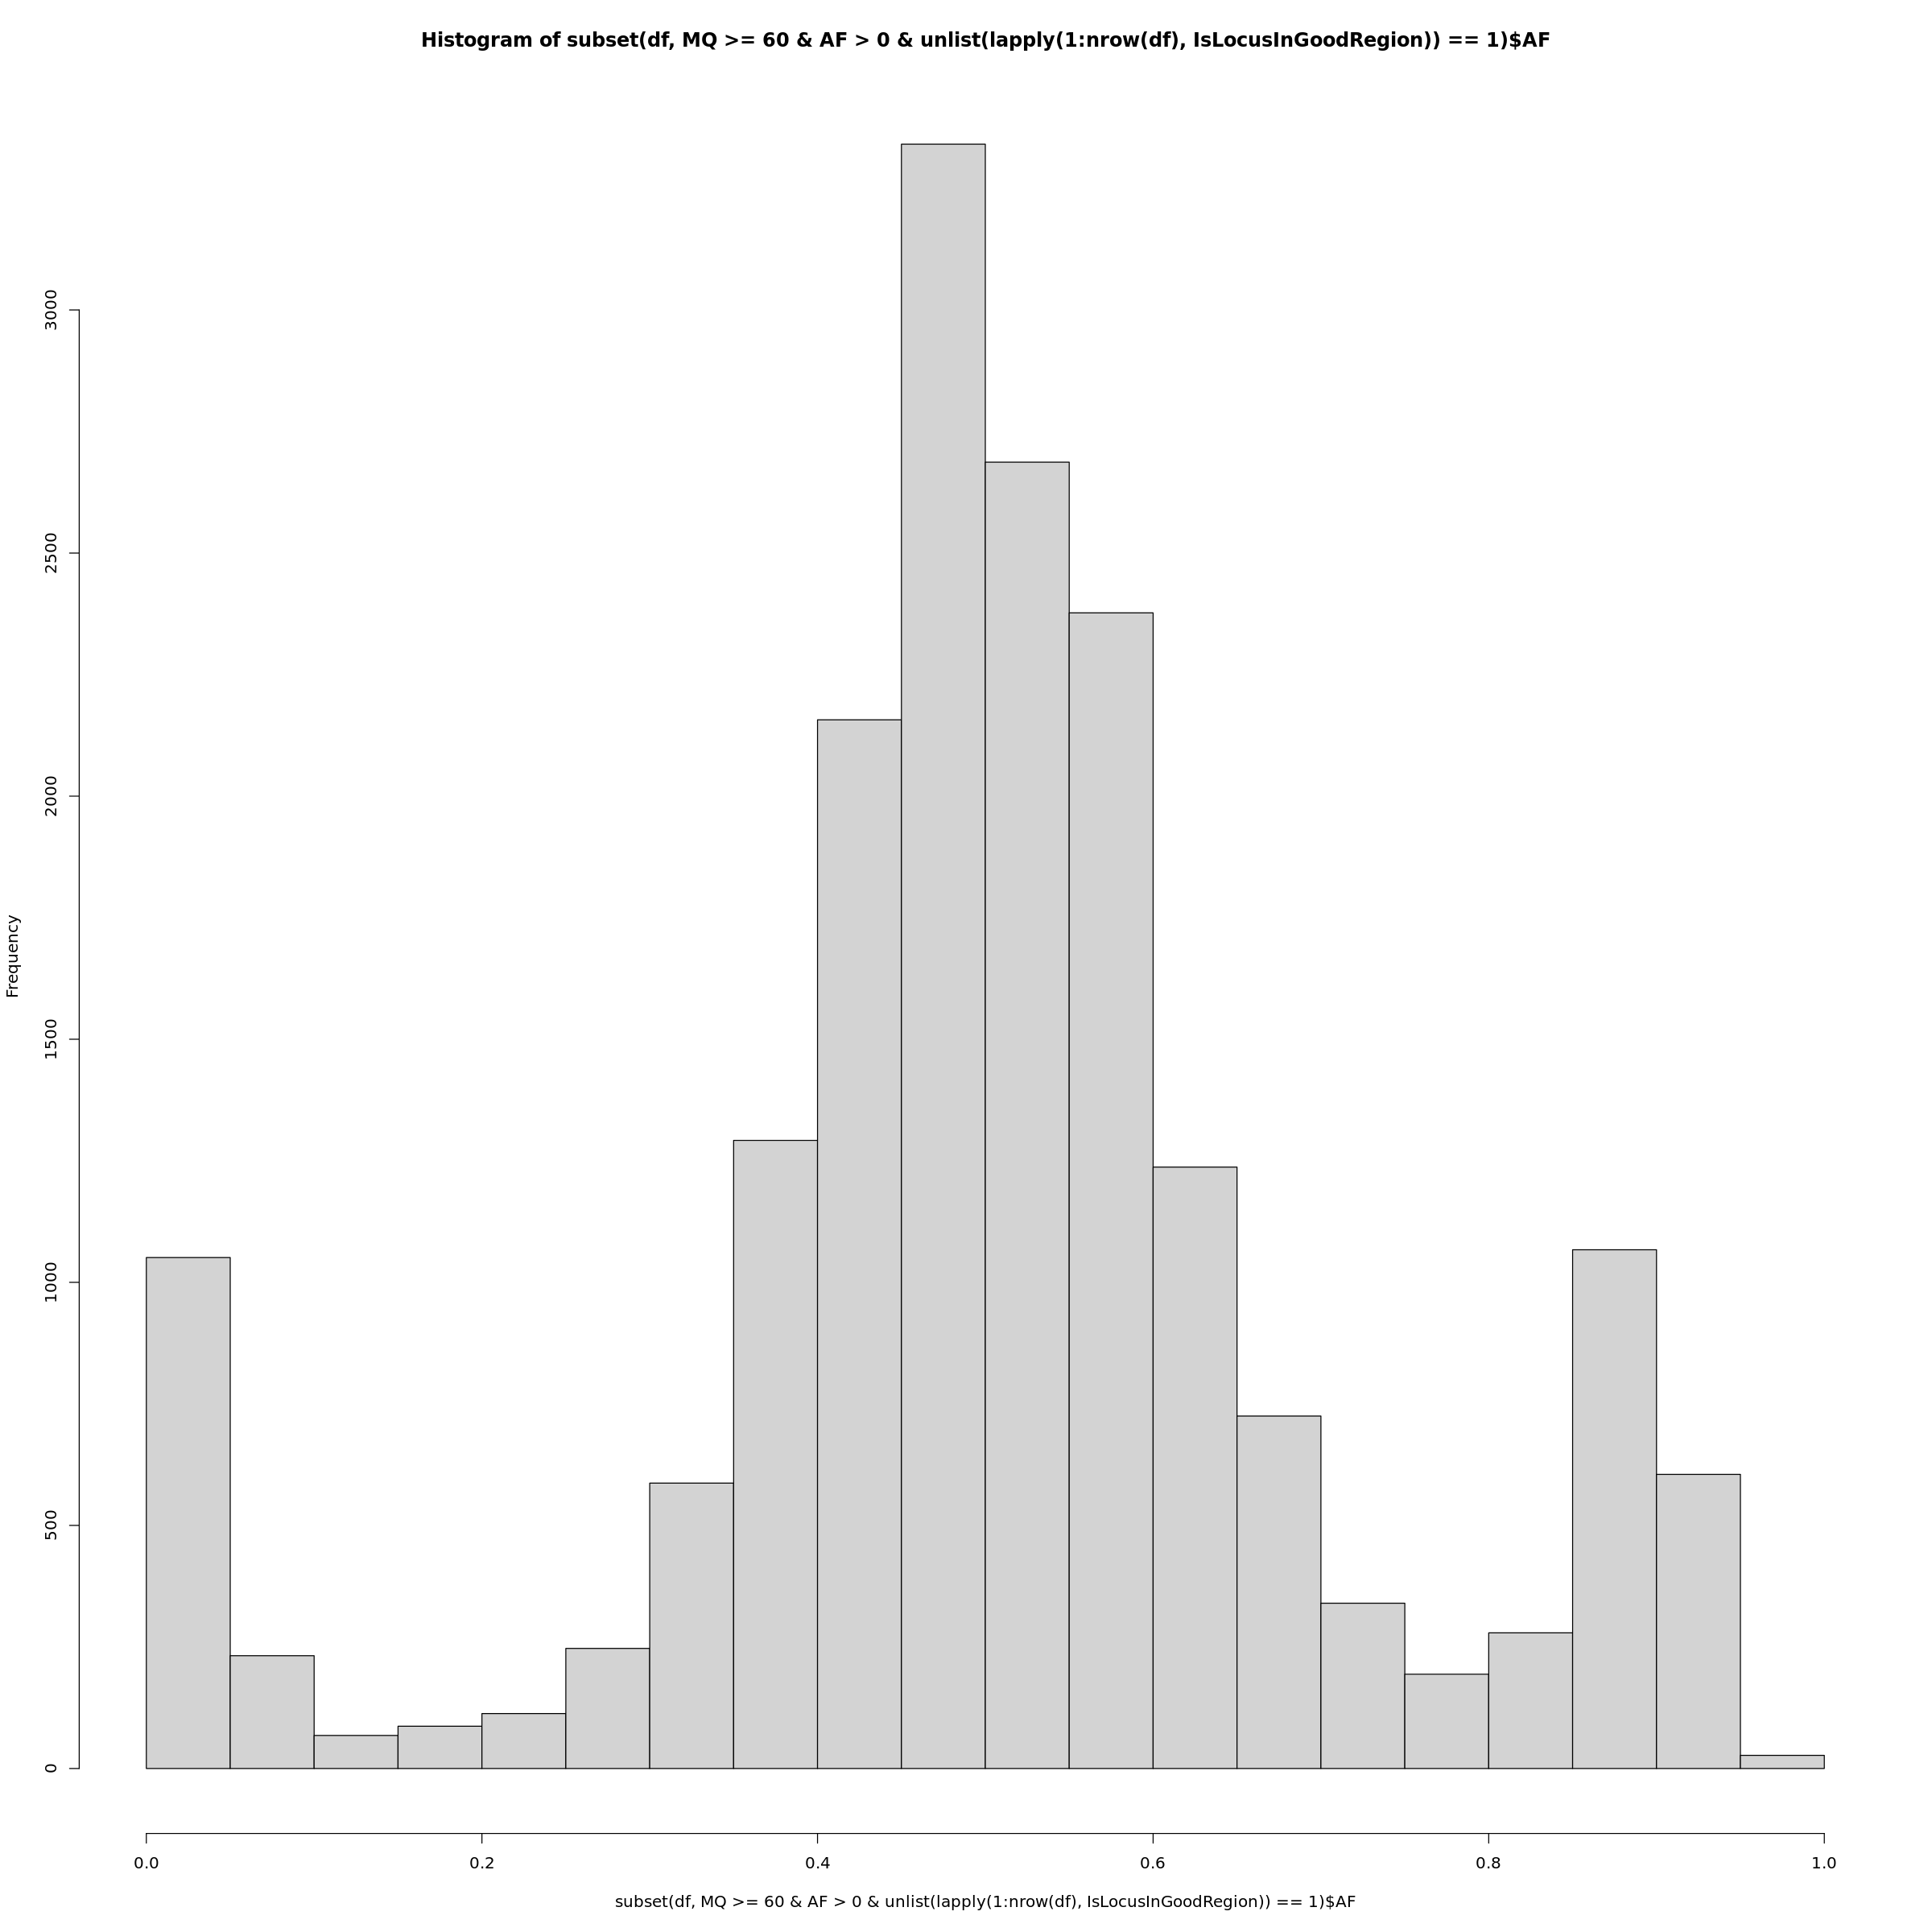

In [94]:
hist(subset(df, MQ>=60 & AF > 0 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1)$AF)

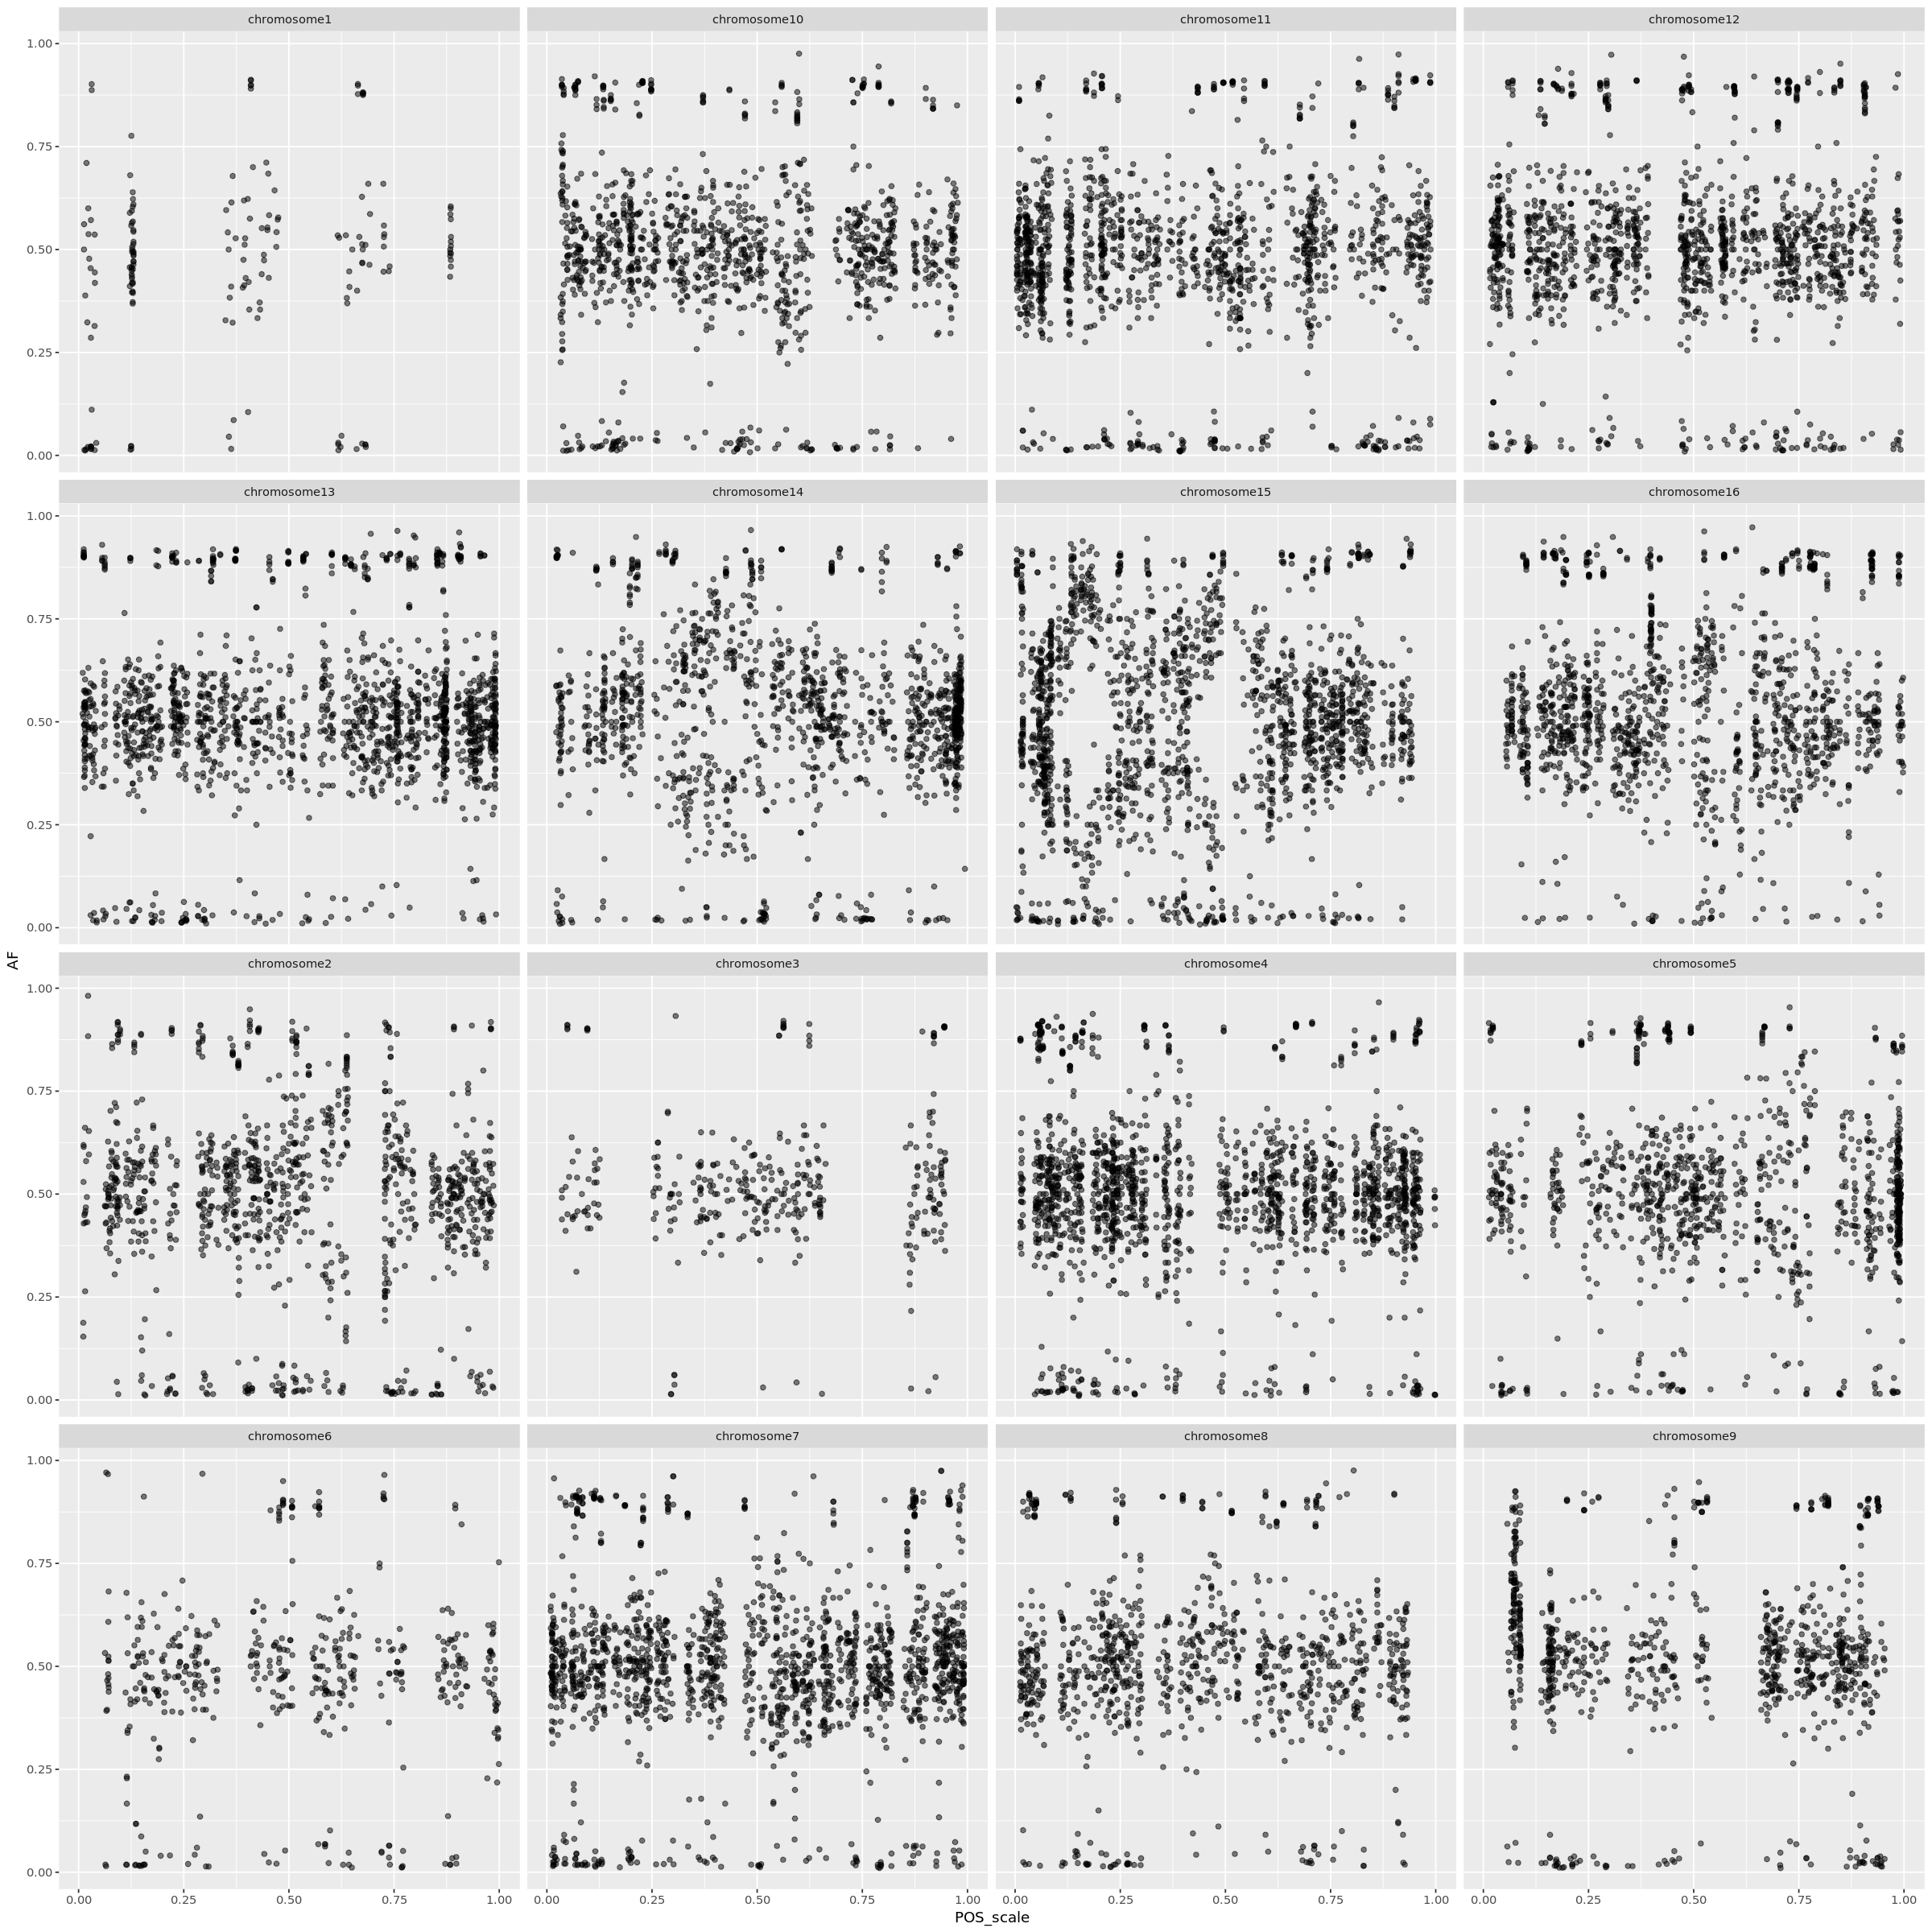

In [93]:
ggplot(subset(df, MQ>=60 & AF > 0 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1), aes(POS_scale, AF))+
geom_point(alpha=0.5)+
facet_wrap(~CHROM)